<a href="https://colab.research.google.com/github/yihan-zhou/fastai/blob/main/week5_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers
! pip install accelerate -U
! pip install transformers[torch]
! pip install datasets

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TrainingArguments,Trainer, AutoModelForSequenceClassification
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [5]:
path_1 = "train_drcat_01.csv" # additional dataset, https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/?select=train_drcat_01.csv
path_2 = "train_essays.csv" # original dataset, https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data?select=train_essays.csv

In [6]:
df_1 = pd.read_csv(path_1)
df_2 = pd.read_csv(path_2)

In [11]:
df_1.head()
# text: Essay text
# label - Is it AI generated?: 1 means AI, 0 means human
# source - Where does it come from: persuade_corpus 78%, llammistral7binstruct 7%, other 15%
# fold: Random 5 fold split for validation

,text,label,source,fold
0,There are alot reasons to keep our the despise...,0,persuade_corpus,2
1,Driving smart cars that drive by themself has ...,0,persuade_corpus,4
2,"Dear Principal,\n\nI believe that students at ...",0,persuade_corpus,0
3,"Dear Principal,\n\nCommunity service should no...",0,persuade_corpus,0
4,My argument for the development of the driverl...,0,persuade_corpus,3


<Axes: >

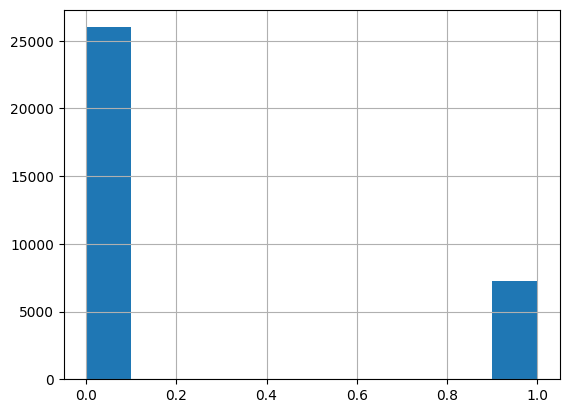

In [12]:
df_1.label.hist()

In [13]:
df_2.head()
# id: A unique identifier for each essay.
# prompt_id:  Identifies the prompt the essay was written in response to.
# Whether the essay was written by a student (0) or generated by an LLM (1)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


<Axes: >

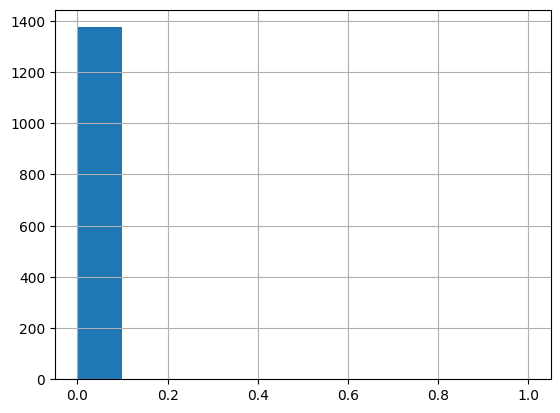

In [14]:
df_2.generated.hist()

In [15]:
df_2.generated.value_counts()

0    1375
1       3
Name: generated, dtype: int64

In [7]:
df_2_student = df_2[df_2['generated']== 0] # the essay was written by a student (0)

In [8]:
cound_df_2=len(df_2_student)//20 #687
print(cound_df_2)

68


In [9]:
df_1_student = df_1[df_1['label'] == 0] #Is it AI generated?: 1 means AI, 0 means human

In [10]:
df_1_AI = df_1[df_1['label'] == 1]
len(df_1_AI)

7263

In [11]:
selected_AI = df_1_AI[['text','label']][:cound_df_2*2]
selected_student_1 = df_1_student[['text', 'label']][:cound_df_2]
selected_student_2 = df_2_student[['text', 'generated']][:cound_df_2]
selected_student_2.columns = ['text', 'label']
df = pd.concat([selected_AI, selected_student_1, selected_student_2])
df.columns = ['text', 'labels']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 7 to 67
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    272 non-null    object
 1   labels  272 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ KB


<Axes: >

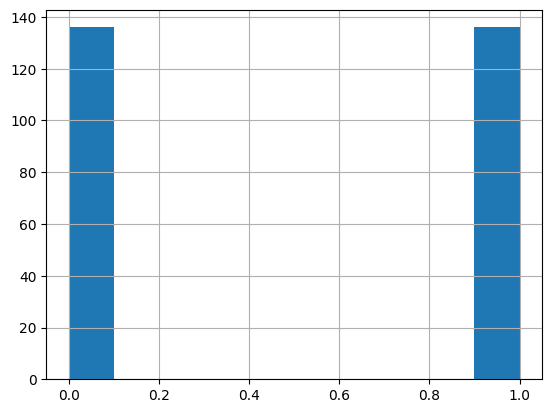

In [12]:
df.labels.hist()

In [13]:
df.head()

,text,labels
7,"As an eighth-grade student, I have noticed tha...",1
10,Studying Science and History at Generic_School...,1
17,"As an artist, I am constantly developing and h...",1
22,After conducting extensive research on the eff...,1
24,The COVID-19 pandemic has brought about a sign...,1


In [14]:
df["labels"] = df["labels"].astype(float)

## Build model

In [15]:
model_nm = 'microsoft/deberta-v3-small'
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
#When num_labels is set to 1, it indicates a binary classification problem, and the model will use a sigmoid function to calculate probabilities.

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
bs = 8
epochs = 4
lr = 8e-5
args = TrainingArguments('outputs', # The output directory where the model predictions and checkpoints
                         logging_steps=10, #Number of update steps between two logs
                         logging_strategy="steps", #Logging is done every logging_steps.
                         learning_rate=lr,
                         warmup_ratio=0.1, #Ratio of total training steps used for a linear warmup from 0 to learning_rate.
                         lr_scheduler_type='cosine',
                         fp16=True,
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=bs,
                         per_device_eval_batch_size=bs*2,
                         gradient_accumulation_steps = 2,
                         num_train_epochs=epochs,
                         weight_decay=0.01,
                         report_to='none')

In [17]:
ds = Dataset.from_pandas(df)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #get the tokenizer
# def tokenizer_func(x): return tokenizer(x["text"], padding=True, truncation=True)
def tok_func(x): return tokenizer(x["text"])
tok_ds = ds.map(tok_func, batched=True)
dds = tok_ds.train_test_split(0.25, seed=42)
def compute_accuracy(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (preds > 0.5).astype(np.int32)
    return {"accuracy": accuracy_score(labels, predictions)}

trainer = Trainer(model,
                  args=args,
                  train_dataset=dds['train'],
                  eval_dataset=dds['test'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_accuracy)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/272 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


In [18]:
torch.cuda.empty_cache()

In [19]:
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,0.416800,0.245904,0.485294
2,0.275300,0.239693,0.485294
3,0.253400,0.224490,0.485294
4,0.182300,0.134346,0.485294


## From scratch deep learning

In [22]:
torch.manual_seed(442)

In [23]:
from torch import tensor

In [64]:
df_train = dds["train"].to_pandas()
df_test = dds["test"].to_pandas()

In [65]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3),sublinear_tf=True)
df_train_tfidf = vectorizer.fit_transform(df_train["text"].values)
df_test_tfidf = vectorizer.transform(df_test["text"].values)

In [82]:
def get_tensor(df):
  df_tfidf = vectorizer.transform(df["text"].values)
  dense_matrix = df_tfidf.toarray()
  t_indeps = torch.tensor(dense_matrix, dtype=torch.float32)
  t_deps = torch.tensor(df["labels"].values, dtype=torch.float32)
  return t_indeps, t_deps


In [66]:
df_train_tfidf.shape, df_test_tfidf.shape

((204, 106889), (68, 106889))

In [67]:
# Convert the sparse matrix to a dense matrix
dense_matrix = df_train_tfidf.toarray()

In [68]:
# Convert the dense matrix to a PyTorch tensor
t_indeps = torch.tensor(dense_matrix, dtype=torch.float32)

In [69]:
# try
t_deps = torch.tensor(df_train["labels"].values, dtype=torch.float32)

In [70]:
t_indeps.shape

torch.Size([204, 106889])

In [72]:
n_coeff = t_indeps.shape[1] #204, the num of rows

In [73]:
coeffs = torch.randn(n_coeff) - 0.5 #generate random coeffs

In [74]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [75]:
def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res) # activation function

In [76]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()


In [77]:
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

In [78]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, t_indeps, t_deps)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [79]:
def train_model(epochs=4, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [80]:
coeffs = train_model(lr=4)

0.495; 0.495; 0.495; 0.495; 

In [83]:
t_val_indeps, t_val_deps = get_tensor(df_test)

In [84]:
def acc(coeffs): return (t_val_deps.bool()==(calc_preds(coeffs, t_val_indeps)>0.5)).float().mean()

In [85]:
acc(coeffs)

tensor(0.4853)

## Splitting into train, test, and validation set

In [54]:
X_train, x_test_temp, Y_train, y_test_temp = train_test_split(df.text, df.label, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test_temp, y_test_temp, test_size=0.5, random_state=42)

## Example of TfidVectorizer

In [29]:
# Sample dataset
documents = ["the sky is blue", "the sun is bright", "the sun in the sky is bright", "we can see the shining sun, the bright sun"]

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform
tfidf_matrix = vectorizer.fit_transform(documents)

# Output the resulting matrix
print(tfidf_matrix.toarray())

[[0.65919112 0.         0.         0.         0.42075315 0.
  0.         0.51971385 0.         0.34399327 0.        ]
 [0.         0.52210862 0.         0.         0.52210862 0.
  0.         0.         0.52210862 0.42685801 0.        ]
 [0.         0.3218464  0.         0.50423458 0.3218464  0.
  0.         0.39754433 0.3218464  0.52626104 0.        ]
 [0.         0.23910199 0.37459947 0.         0.         0.37459947
  0.37459947 0.         0.47820398 0.39096309 0.37459947]]


In [30]:
len(tfidf_matrix.toarray()[0])

11

In [31]:
tfidf_matrix.toarray()[0]

array([0.65919112, 0.        , 0.        , 0.        , 0.42075315,
       0.        , 0.        , 0.51971385, 0.        , 0.34399327,
       0.        ])

In [32]:
feature_names = vectorizer.get_feature_names_out()
for score, word in zip(tfidf_matrix.toarray()[0], feature_names):
    print(word, score)
  # the sky is blue
  # the higher the value, the work being more important to the document

blue 0.6591911178676787
bright 0.0
can 0.0
in 0.0
is 0.42075315164463567
see 0.0
shining 0.0
sky 0.5197138488789809
sun 0.0
the 0.3439932714296342
we 0.0


## Vectorizing the text

In [56]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3),sublinear_tf=True)
# ngram_range=(1, 3),
# the vectorizer considers unigrams (single words),
# bigrams (pairs of consecutive words),
# and trigrams (three consecutive words) as individual features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(x_test)


## Build model
Using the ensemble approach in sklearn.

In [57]:
lr_model = LogisticRegression(solver="liblinear")
sgd_model = SGDClassifier(max_iter=1000, tol=1e-3, loss="modified_huber")
ensemble = VotingClassifier(estimators=[('lr', lr_model),('sgd', sgd_model)], voting='soft')
ensemble.fit(X_train_tfidf, Y_train)
accuray = ensemble.score(X_test_tfidf, y_test)
# it returns the mean accuracy on the given test data and labels.
print(accuray)

0.9985565819861432


In [1]:
ensemble.score([1,1], [0,1])

NameError: ignored

## Build simple neural net

In [190]:
X_train_df = pd.DataFrame(X_train)
x_val_df = pd.DataFrame(x_val)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #get the tokenizer
# using the dataset lib from huggingface to improve the efficiency
train_ds = Dataset.from_pandas(X_train_df)
val_ds = Dataset.from_pandas(x_val_df)

In [192]:
def tokenizer_func(x): return tokenizer(x["text"], padding=True, truncation=True)
token_train_ds = train_ds.map(tokenizer_func, batched=True)
token_val_ds = val_ds.map(tokenizer_func, batched=True)

Map:   0%|          | 0/27709 [00:00<?, ? examples/s]

KeyboardInterrupt: ignored

In [ ]:
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     accuracy = accuracy_score(labels, predictions)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
#     return {
#         'accuracy': accuracy,
#         'f1': f1,
#         'precision': precision,
#         'recall': recall
#     }

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (preds > 0.5).astype(np.int32)
    return {"accuracy": accuracy_score(labels, predictions)}

In [147]:
trainer = Trainer(model,
                  args=args,
                  train_dataset=token_train_ds,
                  eval_dataset=token_val_ds,
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

In [148]:
torch.cuda.empty_cache()

In [ ]:
trainer.train();

## Test

In [206]:
df_sample = df[["text","label"]][:100]
df_sample.columns = ["text", "labels"]

In [207]:
df_sample.head()

,text,labels
0,There are alot reasons to keep our the despise...,0.0
1,Driving smart cars that drive by themself has ...,0.0
2,"Dear Principal,\n\nI believe that students at ...",0.0
3,"Dear Principal,\n\nCommunity service should no...",0.0
4,My argument for the development of the driverl...,0.0


In [ ]:
ds = Dataset.from_pandas(df_sample)
def tok_func(x): return tokenizer(x["text"])
tok_ds = ds.map(tok_func, batched=True)
dds = tok_ds.train_test_split(0.25, seed=42)
def compute_accuracy(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (preds > 0.5).astype(np.int32)
    return {"accuracy": accuracy_score(labels, predictions)}

trainer = Trainer(model,
                  args=args,
                  train_dataset=dds['train'],
                  eval_dataset=dds['test'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_accuracy)
trainer.train();

In [208]:
ds = Dataset.from_pandas(df_sample)
def tok_func(x): return tokenizer(x["text"])
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [209]:
dds = tok_ds.train_test_split(0.25, seed=42)

In [210]:
def compute_accuracy(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (preds > 0.5).astype(np.int32)
    return {"accuracy": accuracy_score(labels, predictions)}

trainer = Trainer(model,
                  args=args,
                  train_dataset=dds['train'],
                  eval_dataset=dds['test'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_accuracy)

In [211]:
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.076665,0.880000
2,No log,0.093002,0.240000
4,0.001700,0.127480,0.240000
6,0.001700,0.107641,0.600000
8,0.003000,0.088968,0.920000
10,0.003000,0.133778,0.880000
12,0.002000,0.113625,0.240000
14,0.002000,0.130659,0.880000
16,0.001300,0.120536,0.640000
18,0.001300,0.124105,0.880000


In [ ]:
# figuring out the perameters of Trainer,TrainingArguments,and tokenization
# compare the accuracy calculation, are they comparable?
# sample 1k and 1k ai and non-ai answer to begin
# use the week 5 neural net from groundup work to train a neural net
# then use deberta-v3-small model
# take the dataset that's splitted from the ds and run the baseline ensemble again see the score

In [1]:
def compute_accuracy(eval_pred):
    logits, labels = eval_pred # input (eval_pred) includes logits and labels
    preds = torch.sigmoid(torch.tensor(logits)).numpy()
    # logits are the raw outputs from the last layer of deep learning network
    # sigmoid function, a type of logistic function, converts the raw outout into final score between 0 and 1
    # torch.sigmoid is part of pytorch lib which optimizes for efficient computation on GPUs
    # after applying sigmoid, the data must be convert back to numpy for further processing/ analysis
    predictions = (preds > 0.5).astype(np.int32)
    return {"accuracy": accuracy_score(labels, predictions)}
    # Accuracy = Number of Correct Predictions / Total Predictions

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # softmax function generates output in the range of 0 to 1 and their total is 1,
    # commonly seen in multi-class classification
    # axis=-1 means that the operation should be performed along the last axis of the array.
    # which often represents the probabilities associated with each possible class for each data point
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }